## Importing Packages

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Dataset of round-robin games

### Without resampling and no feature engineering

The accuracy of the Random Forest Classifier is 0.5244755244755245


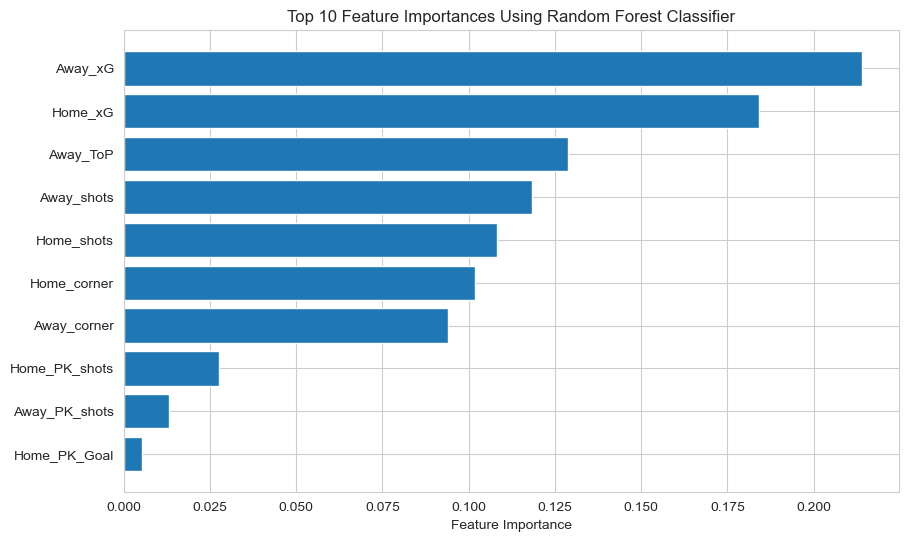

In [9]:
# Reads the file
df = pd.read_csv("NSL_regular_season_data_2.csv")

# This defines if a team wins, draws, or loses.
wdl = []
for index, row in df[['HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore']].iterrows():
    if row['HomeScore'] > row['AwayScore']:
        wdl.append("1")
    elif row['HomeScore'] < row['AwayScore']:
        wdl.append("-1")
    elif row['HomeScore'] == row['AwayScore']:
        wdl.append("0")
    else:
      print("missing")
df[['Result']] = pd.DataFrame(wdl)

# This makes it so that the away team also has a possession statistic.
df['Away_ToP'] = df.apply(lambda row: 
  row['Home_ToP'] - 1,
  axis=1)

# Preparing for the model.
df = df.drop(columns = ['game_id', 'HomeTeam', 'AwayTeam', 'Home_ToP', 'HomeScore', 'AwayScore'])

# This splits the dataset into a training set and a testing set.
train,test=train_test_split(df,test_size=0.3,random_state=0,stratify=df['Result'])
train_X=train.drop(columns='Result', axis = -1)
train_Y=train['Result']
test_X=test.drop(columns='Result', axis = -1)
test_Y=test['Result']

# This builds and tests the model. It then returns the accuracy of the model.
feature_names = [f"feature {i}" for i in range(train_X.shape[1])]
modelRFC = RandomForestClassifier(random_state=5)
modelRFC.fit(train_X, train_Y)
pred = modelRFC.predict(test_X)
print('The accuracy of the Random Forest Classifier is',metrics.accuracy_score(pred,test_Y))

# This is solely to show what features are most important for the model to come to a prediction
def plot_randomForest_feature_importances(model, X, top_n=10, figsize=(10, 6)):

    if not hasattr(model, 'feature_importances_'):
        raise AttributeError("The model does not have the attribute 'feature_importances_'.")

    # Get feature importances from the model
    importances = model.feature_importances_

    # Get indices of the top_n importances
    indices = np.argsort(importances)[-top_n:]

    # Get feature names from the indices
    feature_names = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])

    # Plotting
    plt.figure(figsize=figsize)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances Using Random Forest Classifier')
    plt.show()
plot_randomForest_feature_importances(modelRFC, train_X)

# One problem with this method is that you categorize all home 
# games as one, so you need to actually categorize it team by team
# or come up with some other solution

Something that can be done here is duplicating each game. Then, grab each row that's for a specific team into another list

Change so rather than away or home, it's against and for. Add a variable for either home or away

## Creating new dataset

This block duplicates each game so that every two rows is for the same game. This will allow us to analyze from another perspective. This will allow us to distinguish the team in the game as either playing in a home or away game.

In [10]:

df = pd.read_csv("NSL_regular_season_data_2.csv")

dff = pd.concat([df, df], ignore_index=True)
dff.sort_values(by=dff.columns.tolist(), inplace=True)

dff.reset_index(drop=True, inplace=True)

values = [1, 2] * (len(dff) // 2) + [1] * (len(dff) % 2)
dff['number'] = values

### More details on the making of the DataFrame

In [11]:
fd = pd.DataFrame(columns=['Team', 'goalsFor', 'goalsAgainst', 'xGFor', 'xGAgainst',
                           'shotsFor', 'shotsAgainst', 'cornersFor', 'cornersAgainst',
                           'pkFor', 'pkAgainst', 'pkShotsFor', 'pkShotsAgainst', 'possessionPct', 'isHome', 'Result', 'PointsGained'])
    

In [12]:
for index, row in dff.iterrows():
    if row['number'] == 1:  # Access individual value using row['number']
        fd.at[index, 'Team'] = row['HomeTeam']
        fd.at[index, 'goalsFor'] = row['HomeScore']
        fd.at[index, 'goalsAgainst'] = row['AwayScore']
        fd.at[index, 'xGFor'] = row['Home_xG']
        fd.at[index, 'xGAgainst'] = row['Away_xG']
        fd.at[index, 'shotsFor'] = row['Home_shots']
        fd.at[index, 'shotsAgainst'] = row['Away_shots']
        fd.at[index, 'cornersFor'] = row['Home_corner']
        fd.at[index, 'cornersAgainst'] = row['Away_corner']
        fd.at[index, 'pkFor'] = row['Home_PK_Goal']
        fd.at[index, 'pkAgainst'] = row['Away_PK_Goal']
        fd.at[index, 'pkShotsFor'] = row['Home_PK_shots']
        fd.at[index, 'pkShotsAgainst'] = row['Away_PK_shots']
        fd.at[index, 'possessionPct'] = row['Home_ToP']
        fd.at[index, 'isHome'] = 1 #Team is home

    else:
        fd.at[index, 'Team'] = row['AwayTeam']
        fd.at[index, 'goalsAgainst'] = row['HomeScore']
        fd.at[index, 'goalsFor'] = row['AwayScore']
        fd.at[index, 'xGAgainst'] = row['Home_xG']
        fd.at[index, 'xGFor'] = row['Away_xG']
        fd.at[index, 'shotsAgainst'] = row['Home_shots']
        fd.at[index, 'shotsFor'] = row['Away_shots']
        fd.at[index, 'cornersAgainst'] = row['Home_corner']
        fd.at[index, 'cornersFor'] = row['Away_corner']
        fd.at[index, 'pkAgainst'] = row['Home_PK_Goal']
        fd.at[index, 'pkFor'] = row['Away_PK_Goal']
        fd.at[index, 'pkShotsAgainst'] = row['Home_PK_shots']
        fd.at[index, 'pkShotsFor'] = row['Away_PK_shots']
        fd.at[index, 'possessionPct'] = 1 - row['Home_ToP']
        fd.at[index, 'isHome'] = 0 #Team is away

In [13]:

# Defining a win, loss, or draw

for index, row in fd.iterrows():
    if row['goalsFor'] > row['goalsAgainst']:
        row['Result'] = 1
        row['PointsGained'] = 3
    elif row['goalsAgainst'] > row['goalsFor']:
        row['Result'] = -1
        row['PointsGained'] = 0
    elif row['goalsFor'] == row['goalsAgainst']:
        row['Result'] = 0
        row['PointsGained'] = 1

### Model for Training

In [14]:
fdModel = fd.drop(columns = ['Team', 'goalsFor', 'goalsAgainst', 'PointsGained'])

train,test=train_test_split(fdModel,test_size=0.2,random_state=0,stratify=fdModel['Result'])
train_X=train.drop(columns='Result', axis = -1)
train_Y=train['Result']
test_X=test.drop(columns='Result', axis = -1)
test_Y=test['Result']

In [15]:

feature_names = [f"feature {i}" for i in range(train_X.shape[1])]
modelRFC = RandomForestClassifier(random_state=5)
train_Y=train_Y.astype('int')
test_Y=test_Y.astype('int')
modelRFC.fit(train_X, train_Y)
pred = modelRFC.predict(test_X)
print('The accuracy of the Random Forest Classifier is',metrics.accuracy_score(pred,test_Y))

The accuracy of the Random Forest Classifier is 0.5130890052356021


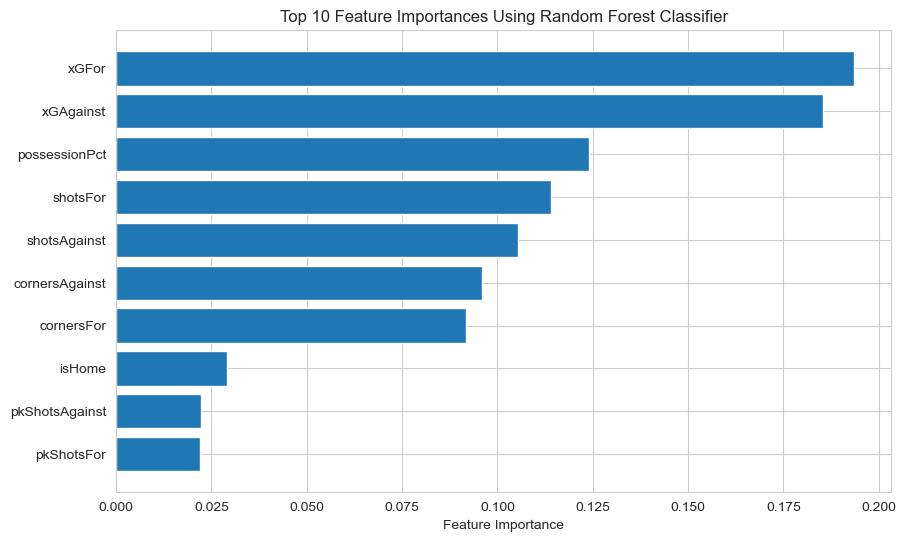

In [16]:

def plot_randomForest_feature_importances(model, X, top_n=10, figsize=(10, 6)):

    if not hasattr(model, 'feature_importances_'):
        raise AttributeError("The model does not have the attribute 'feature_importances_'.")

    # Get feature importances from the model
    importances = model.feature_importances_

    # Get indices of the top_n importances
    indices = np.argsort(importances)[-top_n:]

    # Get feature names from the indices
    feature_names = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])

    # Plotting
    plt.figure(figsize=figsize)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances Using Random Forest Classifier')
    plt.show()
plot_randomForest_feature_importances(modelRFC, train_X)

With very little feature engineering or manipulation of any sort of the initial data, we can see that the model does not perform well. Perhaps this is due to the amount of data we have. Let's look at one resampling technique.

### Creating a resampled dataset

In [17]:
team_0 = fd[fd['Result'] == -1]
team_1 = fd[fd['Result'] == 1]
team_2 = fd[fd['Result'] == 0]
samples = 1000
team_0_resampled = team_0.sample(samples, replace=True)
team_1_resampled = team_1.sample(samples, replace=True)
team_2_resampled = team_2.sample(samples, replace=True)

team = pd.concat([team_0_resampled, team_1_resampled, team_2_resampled], axis=0)
print(team['Result'].value_counts())

Result
-1    1000
1     1000
0     1000
Name: count, dtype: int64


The method above uses the same data points already provided to attempt to balance the data. By using ```.sample```, the code effectively pulls from the original data to replicate more of the same data. 


<table>
<tr><th>Original Data</th><th>Resampled Data</th></tr>
<tr><td>

| Input    | Output |
| -------- | ------- |
| A  | 1    |
| B | 2     |
| C    | 3    |

</td><td>

| Input    | Output |
| -------- | ------- |
| A  | 1    |
| B | 2     |
| C    | 3    |
| C  | 3    |
| C | 3     |
| A    | 1 |
| B    | 2 |

</td></tr> </table>

Above is a small demonstration of what happens with this resampling method.

Training with this data does three things.
1) It enables the model to work with more data
2) It convinces the model to use the same data over and over again, thus weighting it more
3) It tests the model on data that it trained on

The problem lies with the last two points.

Point 2: By using the same data over and over again, it creates a bias towards that data. While it may be argued that these samples are randomly chosen, there is already such little data for each team that it just doesn't matter. There's so many repititions on the same data which leads to overfitting.

Point 3: The data for testing is the same data that the training set has. This means that it learns from the training data to build a model for those few data points. This also creates overfitting, which means if you give the set new data to work with, it won't perform well. 


### Training the model on the resampled data

In [18]:
resampleModel = team.drop(columns = ['Team', 'goalsFor', 'goalsAgainst', 'xGFor', 'xGAgainst', 'PointsGained'])

train,test=train_test_split(resampleModel,test_size=0.3,random_state=0,stratify=resampleModel['Result'])
train_X=train.drop(columns='Result', axis = -1)
train_Y=train['Result']
test_X=test.drop(columns='Result', axis = -1)
test_Y=test['Result']

In [19]:

feature_names = [f"feature {i}" for i in range(train_X.shape[1])]
modelRFC = RandomForestClassifier(random_state=5)
train_Y=train_Y.astype('int')
test_Y=test_Y.astype('int')
modelRFC.fit(train_X, train_Y)
pred = modelRFC.predict(test_X)
print('The accuracy of the Random Forest Classifier is',metrics.accuracy_score(pred,test_Y))

The accuracy of the Random Forest Classifier is 0.9333333333333333


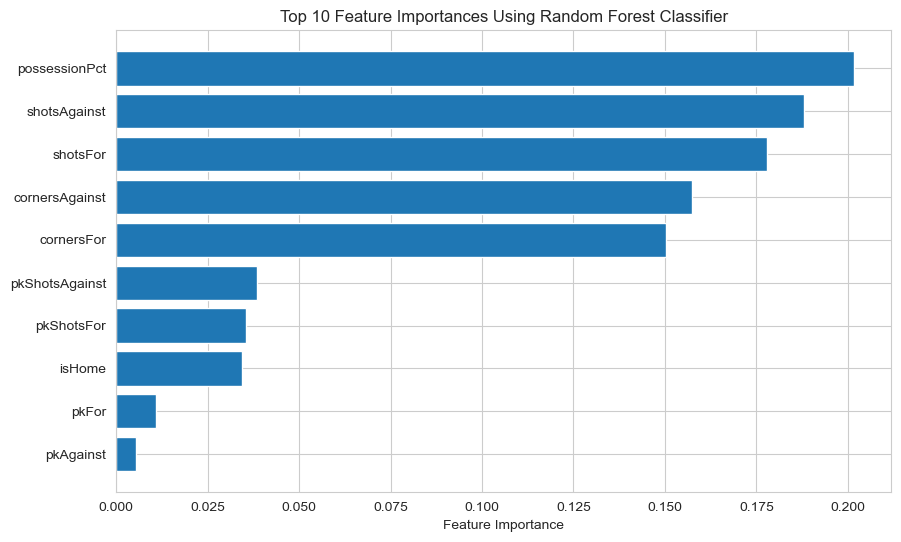

In [20]:

def plot_randomForest_feature_importances(model, X, top_n=10, figsize=(10, 6)):

    if not hasattr(model, 'feature_importances_'):
        raise AttributeError("The model does not have the attribute 'feature_importances_'.")

    # Get feature importances from the model
    importances = model.feature_importances_

    # Get indices of the top_n importances
    indices = np.argsort(importances)[-top_n:]

    # Get feature names from the indices
    feature_names = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])

    # Plotting
    plt.figure(figsize=figsize)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances Using Random Forest Classifier')
    plt.show()
plot_randomForest_feature_importances(modelRFC, train_X)


As you can seem the model performs exceedingly well. This is because of the way the data is resampled. There are alternative ways to resample the data that can potentially provide similar results, so resampling data is not fully out of scope.